In [41]:
import numpy as np
import pandas as pd

from itertools import groupby
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pandas.api.types import is_datetime64_ns_dtype

import lightgbm as lgb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings("ignore")

In [42]:
TRAIN_PATH = '/kaggle/input/zzz-data/Zzzs_train.parquet'

In [43]:
series_id  = pd.read_parquet(TRAIN_PATH, columns=['series_id'])
series_id = series_id['series_id'].unique()

weird_series = ['31011ade7c0a', 'a596ad0b82aa']
series_id = [s for s in series_id if s not in weird_series]

In [44]:
def basic_fe(df, periods):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float16)
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float16)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        for p in periods:
            rol_args = {'window':f'{p+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['mean', 'max', 'min']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float16).values
                gc.collect()
            # There was an overflow error when trying to cast to float16, so I decided to leave it as float32
            for agg in ['var']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()

            
            df[f'{col}_{p}_amplit'] = df[f'{col}_{p}_max'] - df[f'{col}_{p}_min']
            df[f'{col}_diff_{p}_max'] = df[f'{col}_{p}_max'].diff().abs().rolling(**rol_args).max().astype(np.float16)
            df[f'{col}_diff_{p}_mean'] = df[f'{col}_{p}_min'].diff().abs().rolling(**rol_args).mean().astype(np.float16)
            gc.collect()
 
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    gc.collect()

    return df

In [45]:
def feat_eng_by_id(idx, periods):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df = pd.read_parquet(TRAIN_PATH, filters=[('series_id','=',idx)])
    df['awake'] = df['awake'].astype(np.int8)
    df = basic_fe(df, periods)
    
    return df

In [46]:
periods = [60, 300, 600, 3600] 

In [47]:
%%time

df = Parallel(n_jobs=-2)(delayed(feat_eng_by_id)(i, periods) for i in series_id)
df = pd.concat(df, ignore_index=True)

/tmp/ipykernel_47/163733593.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
/tmp/ipykernel_47/163733593.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
/tmp/ipykernel_47/163733593.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `objec

CPU times: user 5.25 s, sys: 8.99 s, total: 14.2 s
Wall time: 4min 14s


In [48]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

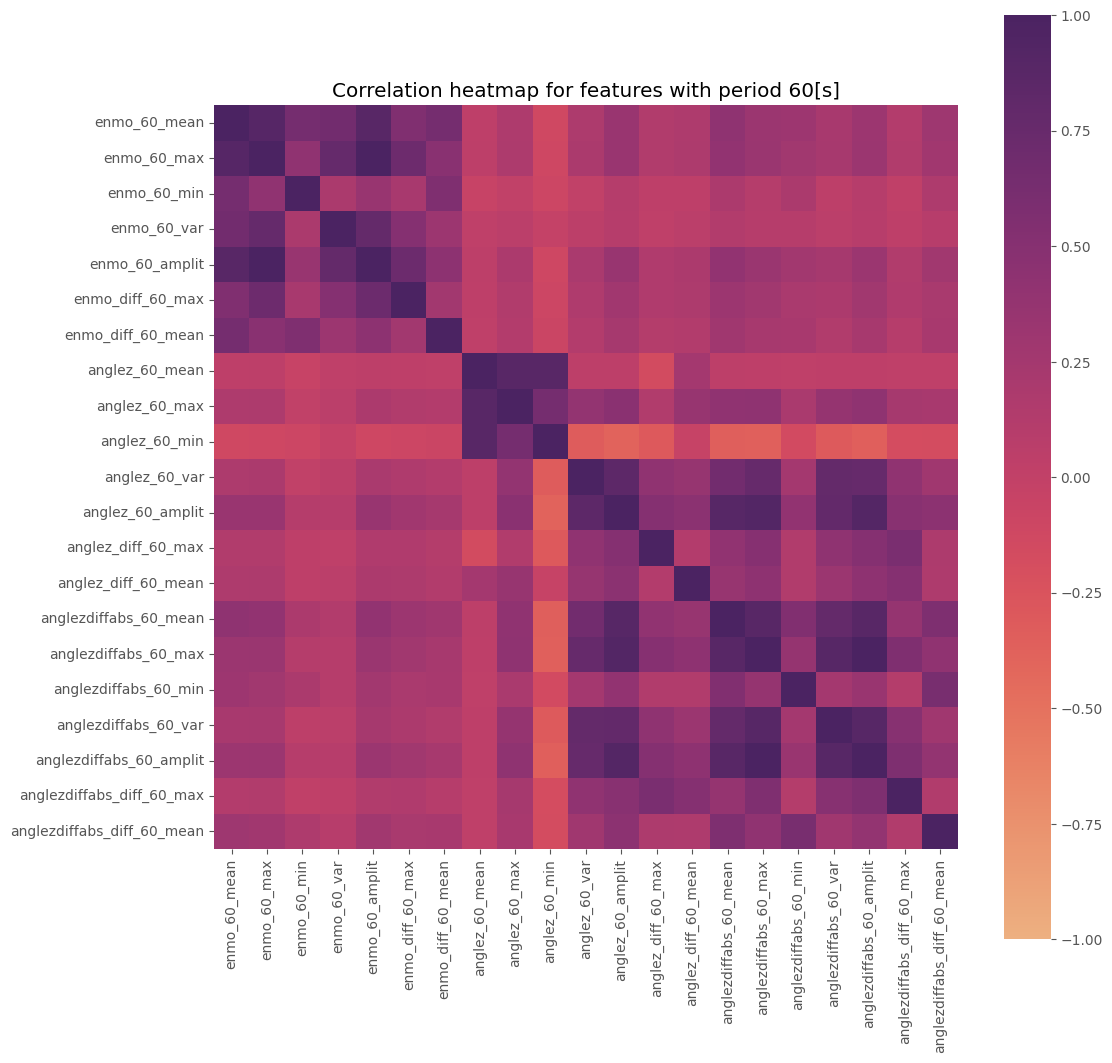

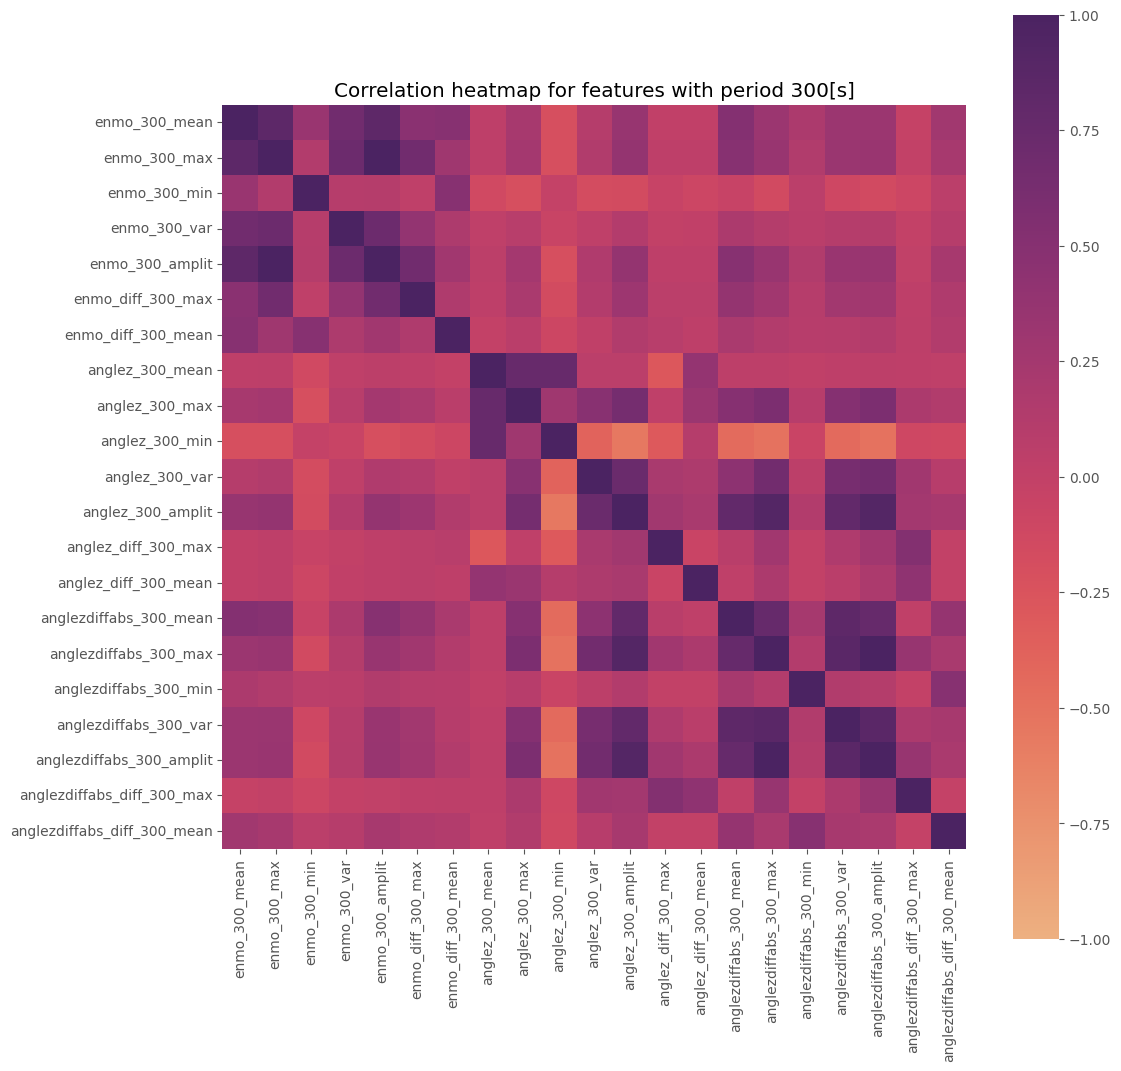

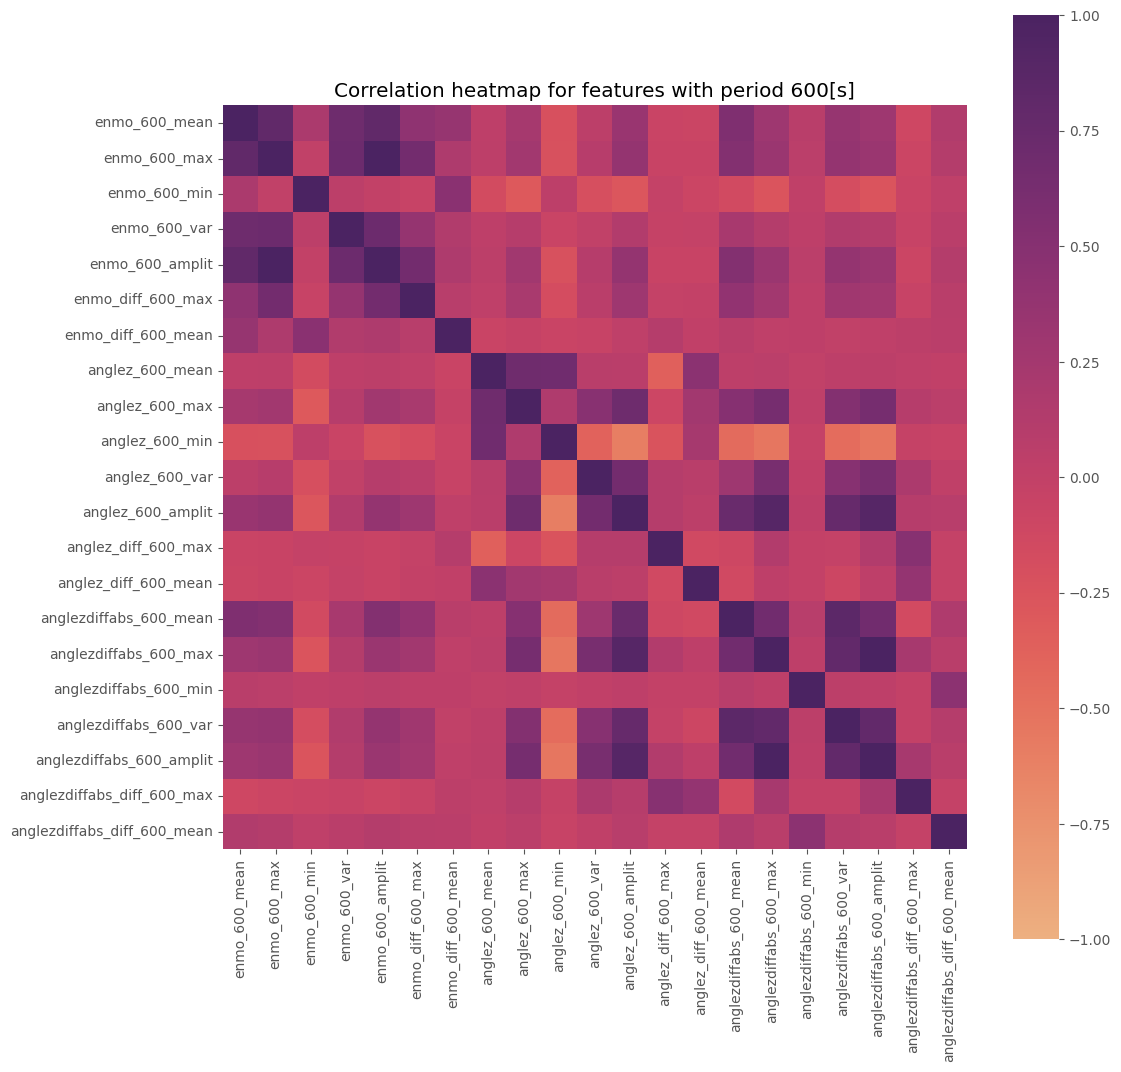

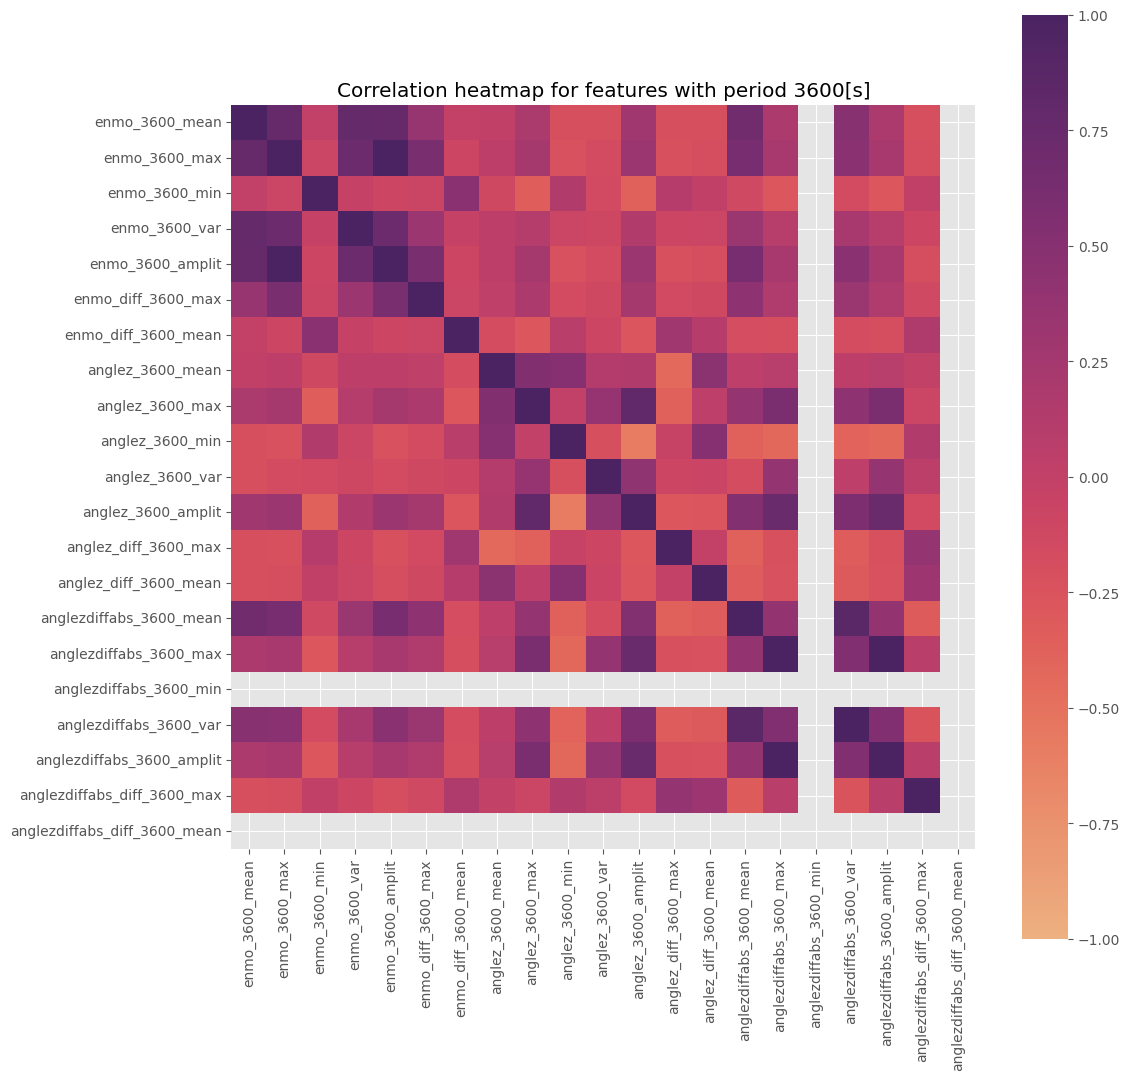

In [49]:
for p in periods:
    plt.figure(figsize=(12,12))
    plt.title(f"Correlation heatmap for features with period {p}[s]")
    sns.heatmap(df[features].filter(like=f'_{p}_').corr(),
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("flare", as_cmap=True),
    square=True)
    plt.show() 

In [50]:
features_to_drop = ['anglezdiffabs_3600_min', 'anglezdiffabs_600_min', 'anglezdiffabs_diff_3600_mean', 'anglezdiffabs_diff_600_mean',
                        'enmo_3600_min', 'enmo_600_min']
for p in periods:
    features_to_drop.append(f'anglezdiffabs_{p}_amplit')
    features_to_drop.append(f'enmo_{p}_amplit')

In [51]:
corr_with_target = df[features].corrwith(df['awake'])
corr_with_target.abs().sort_values().tail(50)

anglez_3600_min                 0.300191
anglez_3600_max                 0.301631
anglez_diff_3600_mean           0.302583
enmo_60_max                     0.305192
anglezdiffabs_diff_60_max       0.314172
enmo_diff_300_max               0.317025
anglezdiffabs_diff_3600_max     0.320073
anglezdiffabs_60_var            0.322677
enmo_60_mean                    0.325824
anglez_diff_60_max              0.337915
anglez_diff_60_mean             0.339530
anglezdiffabs_diff_60_mean      0.344148
anglezdiffabs                   0.347098
enmo_diff_600_max               0.348327
anglez_300_min                  0.360647
anglez_diff_3600_max            0.363111
enmo_300_max                    0.368225
enmo_300_amplit                 0.369672
anglez_600_min                  0.380604
anglez_300_max                  0.385129
enmo_300_mean                   0.387068
enmo_600_max                    0.404006
anglez_600_max                  0.405358
enmo_600_amplit                 0.405517
enmo_diff_3600_m

In [52]:
features_for_heatmap = corr_with_target.abs().sort_values().tail(27).index.to_list()
features_for_heatmap = [f for f in features_for_heatmap if f not in ['anglezdiffabs_3600_min','anglezdiffabs_diff_3600_mean']]

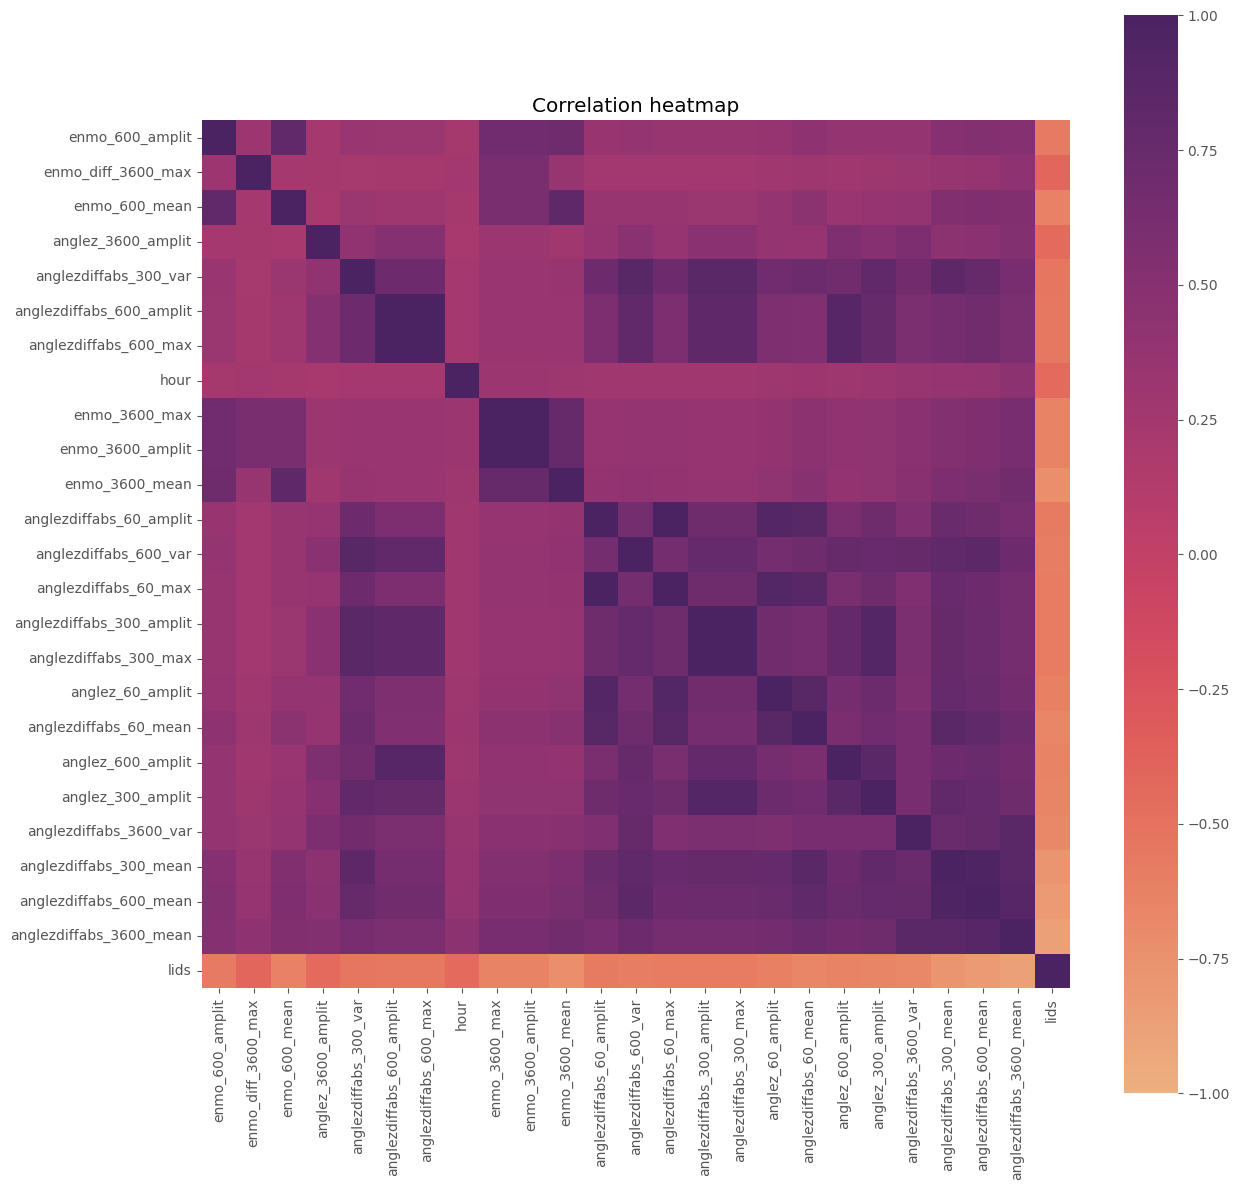

In [53]:
plt.figure(figsize=(14,14))
plt.title(f"Correlation heatmap")
sns.heatmap(df[features_for_heatmap].corr(),
vmin=-1, vmax=1, center=0,
cmap=sns.color_palette("flare", as_cmap=True),
square=True)
plt.show() 

In [54]:
df = df[::50]

### LightGBM

In [55]:
lgb_params = {
'boosting_type':'gbdt',
'num_leaves':35,
'max_depth':6,
'learning_rate':0.03,
'n_estimators':850,
'subsample_for_bin':200000,
'min_child_weight':0.001,
'min_child_samples':20,
'subsample':0.9,
'reg_alpha':0.05,
'reg_lambda':0.05,
'verbose': -1
}

In [56]:
def train_model(df, cv):
    
    drop_cols = ['series_id', 'step', 'timestamp']
    X, y = df.drop(columns=drop_cols+['awake']), df['awake']
    gc.collect()
    
    cv_split = cv.split(X)
    models = []
    mean_f1 = 0
    mean_acc = 0
    
    for i, (train_index, test_index) in enumerate(cv_split):

        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        print(f"Fitting model {i+1} of {cv.n_splits}")
        
        model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, **lgb_params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds)
        acc = accuracy_score(y_test, preds)
        print(f"Fold {i+1} finished training\n F1:{f1_score(y_test, preds)} | Acc:{accuracy_score(y_test, preds)}")
        mean_f1 += f1
        mean_acc += acc
        models.append(model)
        
    print('-'*50)
    print(f"Training finished\nF1: {mean_f1 / cv.n_splits}, Acc: {mean_acc / cv.n_splits}")   
    gc.collect()
    
    return models

In [57]:
print(f"Fitting model with all {len(features)} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with all 89 features
Fitting model 1 of 5
Fold 1 finished training
 F1:0.9874849194005553 | Acc:0.9836501395719792
Fitting model 2 of 5
Fold 2 finished training
 F1:0.987220679528372 | Acc:0.9833083306431705
Fitting model 3 of 5
Fold 3 finished training
 F1:0.9875435829921442 | Acc:0.9836498290922902
Fitting model 4 of 5
Fold 4 finished training
 F1:0.9877193998725599 | Acc:0.9838966957842765
Fitting model 5 of 5
Fold 5 finished training
 F1:0.9870712247393861 | Acc:0.9831371059627801
--------------------------------------------------
Training finished
F1: 0.9874079613066036, Acc: 0.9835284202108994


In [58]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])

In [59]:
fi

,anglez,enmo,hour,lids,anglezdiffabs,enmo_60_mean,enmo_60_max,enmo_60_min,enmo_60_var,enmo_60_amplit,enmo_diff_60_max,enmo_diff_60_mean,enmo_300_mean,enmo_300_max,enmo_300_min,enmo_300_var,enmo_300_amplit,enmo_diff_300_max,enmo_diff_300_mean,enmo_600_mean,enmo_600_max,enmo_600_min,enmo_600_var,enmo_600_amplit,enmo_diff_600_max,enmo_diff_600_mean,enmo_3600_mean,enmo_3600_max,enmo_3600_min,enmo_3600_var,enmo_3600_amplit,enmo_diff_3600_max,enmo_diff_3600_mean,anglez_60_mean,anglez_60_max,anglez_60_min,anglez_60_var,anglez_60_amplit,anglez_diff_60_max,anglez_diff_60_mean,anglez_300_mean,anglez_300_max,anglez_300_min,anglez_300_var,anglez_300_amplit,anglez_diff_300_max,anglez_diff_300_mean,anglez_600_mean,anglez_600_max,anglez_600_min,anglez_600_var,anglez_600_amplit,anglez_diff_600_max,anglez_diff_600_mean,anglez_3600_mean,anglez_3600_max,anglez_3600_min,anglez_3600_var,anglez_3600_amplit,anglez_diff_3600_max,anglez_diff_3600_mean,anglezdiffabs_60_mean,anglezdiffabs_60_max,anglezdiffabs_60_min,anglezdiffabs_60_var,anglezdiffabs_60_amplit,anglezdiffabs_diff_60_max,anglezdiffabs_diff_60_mean,anglezdiffabs_300_mean,anglezdiffabs_300_max,anglezdiffabs_300_min,anglezdiffabs_300_var,anglezdiffabs_300_amplit,anglezdiffabs_diff_300_max,anglezdiffabs_diff_300_mean,anglezdiffabs_600_mean,anglezdiffabs_600_max,anglezdiffabs_600_min,anglezdiffabs_600_var,anglezdiffabs_600_amplit,anglezdiffabs_diff_600_max,anglezdiffabs_diff_600_mean,anglezdiffabs_3600_mean,anglezdiffabs_3600_max,anglezdiffabs_3600_min,anglezdiffabs_3600_var,anglezdiffabs_3600_amplit,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,217,103,2425,650,36,114,49,98,131,39,93,44,127,73,55,139,48,124,61,277,96,120,128,70,298,123,904,617,125,938,376,1854,546,104,234,203,113,110,59,115,135,159,177,117,67,69,125,118,246,324,93,109,216,326,760,896,1052,703,722,1332,1088,153,8,1,58,12,75,18,149,51,0,63,15,110,0,523,86,0,160,0,269,10,1586,1373,0,1023,0,1595,0
1,190,94,2294,713,58,122,63,107,104,49,92,63,114,93,59,191,58,120,39,262,101,97,141,74,258,119,872,726,147,909,444,1778,499,111,221,191,97,102,79,150,131,176,196,127,64,85,169,138,249,340,136,84,201,284,754,879,1119,611,650,1317,999,137,12,4,66,11,82,23,189,81,0,91,3,130,1,497,78,1,163,4,306,8,1622,1299,0,1028,0,1526,0
2,146,82,2444,644,43,101,58,105,123,70,77,43,131,60,62,188,34,90,84,282,158,131,176,89,241,125,941,689,156,902,404,1705,582,100,206,146,100,85,73,132,101,165,180,104,60,67,109,128,232,345,162,110,245,265,742,923,1119,732,720,1299,1004,128,8,7,53,12,55,19,190,68,1,86,8,114,1,507,93,0,172,2,248,12,1568,1313,0,988,0,1578,0
3,191,63,2548,710,17,123,53,124,109,72,92,54,125,71,68,167,51,80,62,252,151,90,163,71,250,105,902,707,141,878,406,1841,503,98,194,194,106,103,73,93,129,187,191,108,59,81,151,145,201,310,102,101,211,297,688,952,1126,725,637,1389,1118,169,27,10,47,4,58,35,191,49,4,55,17,75,0,547,95,1,144,5,252,3,1585,1390,0,1016,0,1545,0
4,168,63,2557,702,32,113,70,125,137,45,103,54,126,95,94,174,37,95,62,297,118,66,164,94,289,147,924,652,142,933,303,1799,567,128,207,173,128,94,71,79,109,168,161,113,46,101,117,124,207,350,129,93,218,309,790,847,1043,801,697,1327,1073,165,34,1,36,8,64,11,229,54,1,77,27,101,0,525,111,0,167,1,261,2,1580,1281,0,1004,0,1526,0


In [60]:
feature_importance = fi.mean(axis=0).sort_values()

<Axes: >

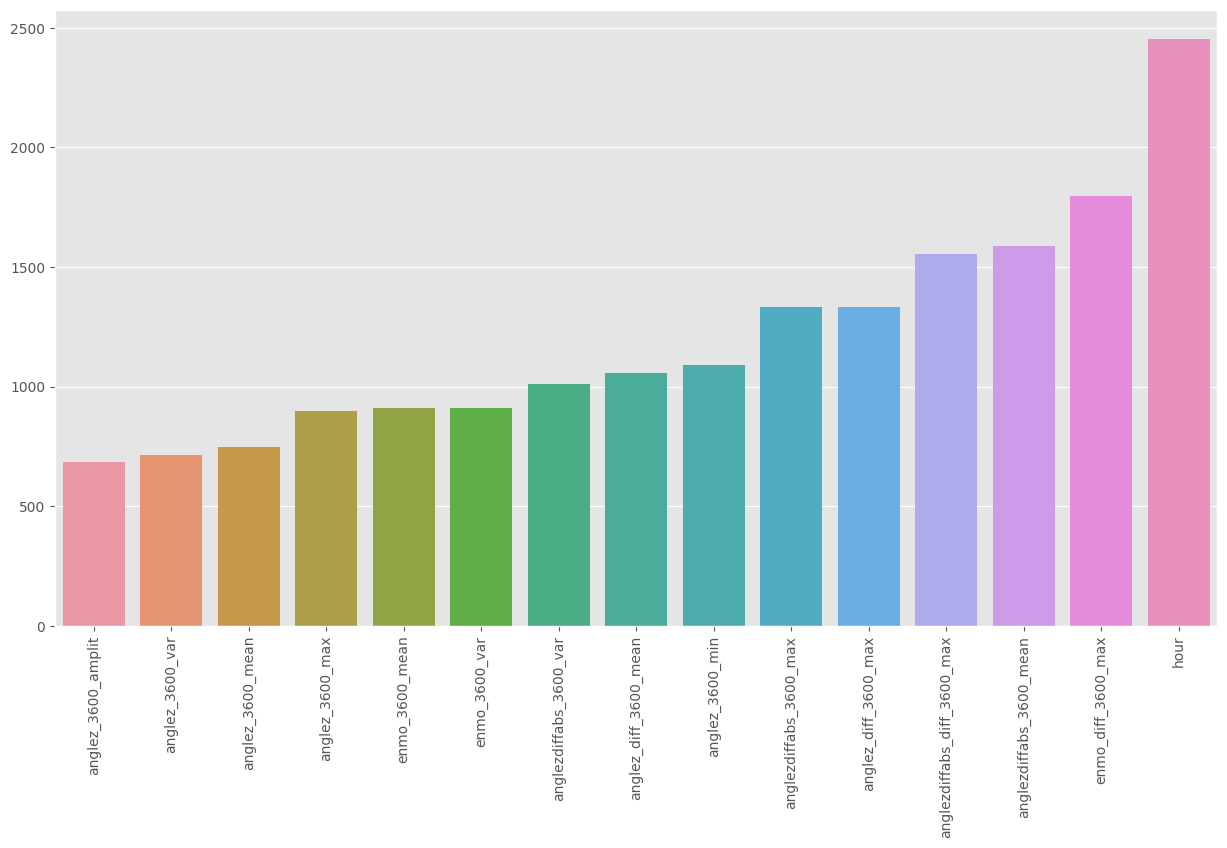

In [61]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)

In [62]:
df = df.drop(columns=features_to_drop)

In [63]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [64]:
for col in df.columns.to_list():
    if col not in ['hour', 'series_id', 'step', 'timestamp', 'awake']:
        df[f'{col}_lag_-1'] = df[col].shift(-1).astype("float16")
        df[f'{col}_lag_1'] = df[col].shift(1).astype("float16")

In [65]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [66]:
features_to_drop = feature_importance.filter(like='_lag_1').head(25).index.to_list() +\
                   feature_importance.filter(like='_lag_-1').head(25).index.to_list()
df = df.drop(columns=features_to_drop)

In [67]:
print(f"Fitting model with {len(df.columns)-4} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with 223 features
Fitting model 1 of 5
Fold 1 finished training
 F1:0.9880509361553669 | Acc:0.9843907255843983
Fitting model 2 of 5
Fold 2 finished training
 F1:0.9877236363636364 | Acc:0.9839729591158543
Fitting model 3 of 5
Fold 3 finished training
 F1:0.9883663724497177 | Acc:0.9847322445879225
Fitting model 4 of 5
Fold 4 finished training
 F1:0.9882513146648509 | Acc:0.9845993163691606
Fitting model 5 of 5
Fold 5 finished training
 F1:0.9876658269138355 | Acc:0.9839156855298139
--------------------------------------------------
Training finished
F1: 0.9880116173094816, Acc: 0.98432218623743


In [68]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=model.booster_.feature_name()) for model in models])
feature_importance = fi.mean(axis=0).sort_values()

In [69]:
candidates = feature_importance.tail(20).index.to_list()
for feature1 in candidates:
    df[f'{feature1}_SQR'] = df[feature1] * df[feature1]
    for feature2 in candidates:
        if feature1 != feature2:
            df[f'{feature1}_MUL_{feature2}'] = df[feature1] * df[feature2]
            df[f'{feature1}_DIV_{feature2}'] = df[feature1] / df[feature2]

In [70]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [74]:
print(f"Fitting model with {len(features)} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with 1003 features
Fitting model 1 of 5
Fold 1 finished training
 F1:0.9899822875228664 | Acc:0.9868973243956628
Fitting model 2 of 5
Fold 2 finished training
 F1:0.9904396594310289 | Acc:0.9875049847135451
Fitting model 3 of 5
Fold 3 finished training
 F1:0.9900371618202063 | Acc:0.9869160653247246
Fitting model 4 of 5
Fold 4 finished training
 F1:0.9906661071154653 | Acc:0.9877516141283706
Fitting model 5 of 5
Fold 5 finished training
 F1:0.9898061570229906 | Acc:0.9866881883782758
--------------------------------------------------
Training finished
F1: 0.9901862745825115, Acc: 0.9871516353881159


<Axes: >

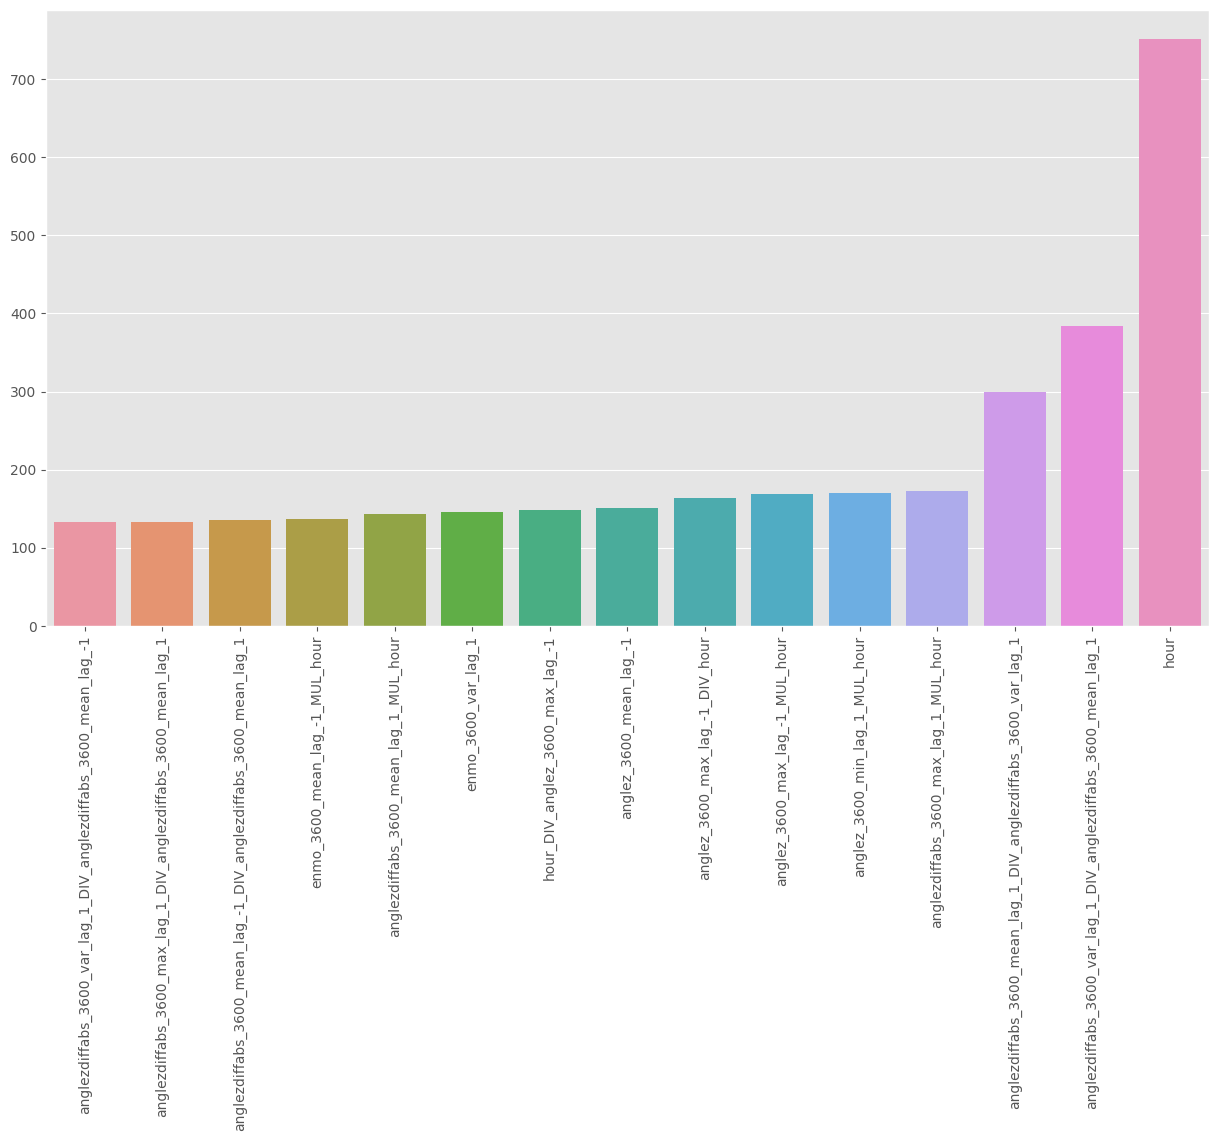

In [75]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])
feature_importance = fi.mean(axis=0).sort_values()
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)

In [76]:
features_to_drop = feature_importance.head(800).index.to_list()
df_light = df.drop(columns=features_to_drop)

In [77]:
features = [col for col in df_light.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [78]:
print(f"Fitting model with {len(features)} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df_light, kf)

Fitting model with 203 features
Fitting model 1 of 5
Fold 1 finished training
 F1:0.9907849482651034 | Acc:0.987941740567023
Fitting model 2 of 5
Fold 2 finished training
 F1:0.9904678872420809 | Acc:0.9875429634834128
Fitting model 3 of 5
Fold 3 finished training
 F1:0.9904001850566736 | Acc:0.9873908089631599
Fitting model 4 of 5
Fold 4 finished training
 F1:0.9911158698923486 | Acc:0.9883402962400304
Fitting model 5 of 5
Fold 5 finished training
 F1:0.9903931400334277 | Acc:0.9874477781997721
--------------------------------------------------
Training finished
F1: 0.9906324060979269, Acc: 0.9877327174906796


<Axes: >

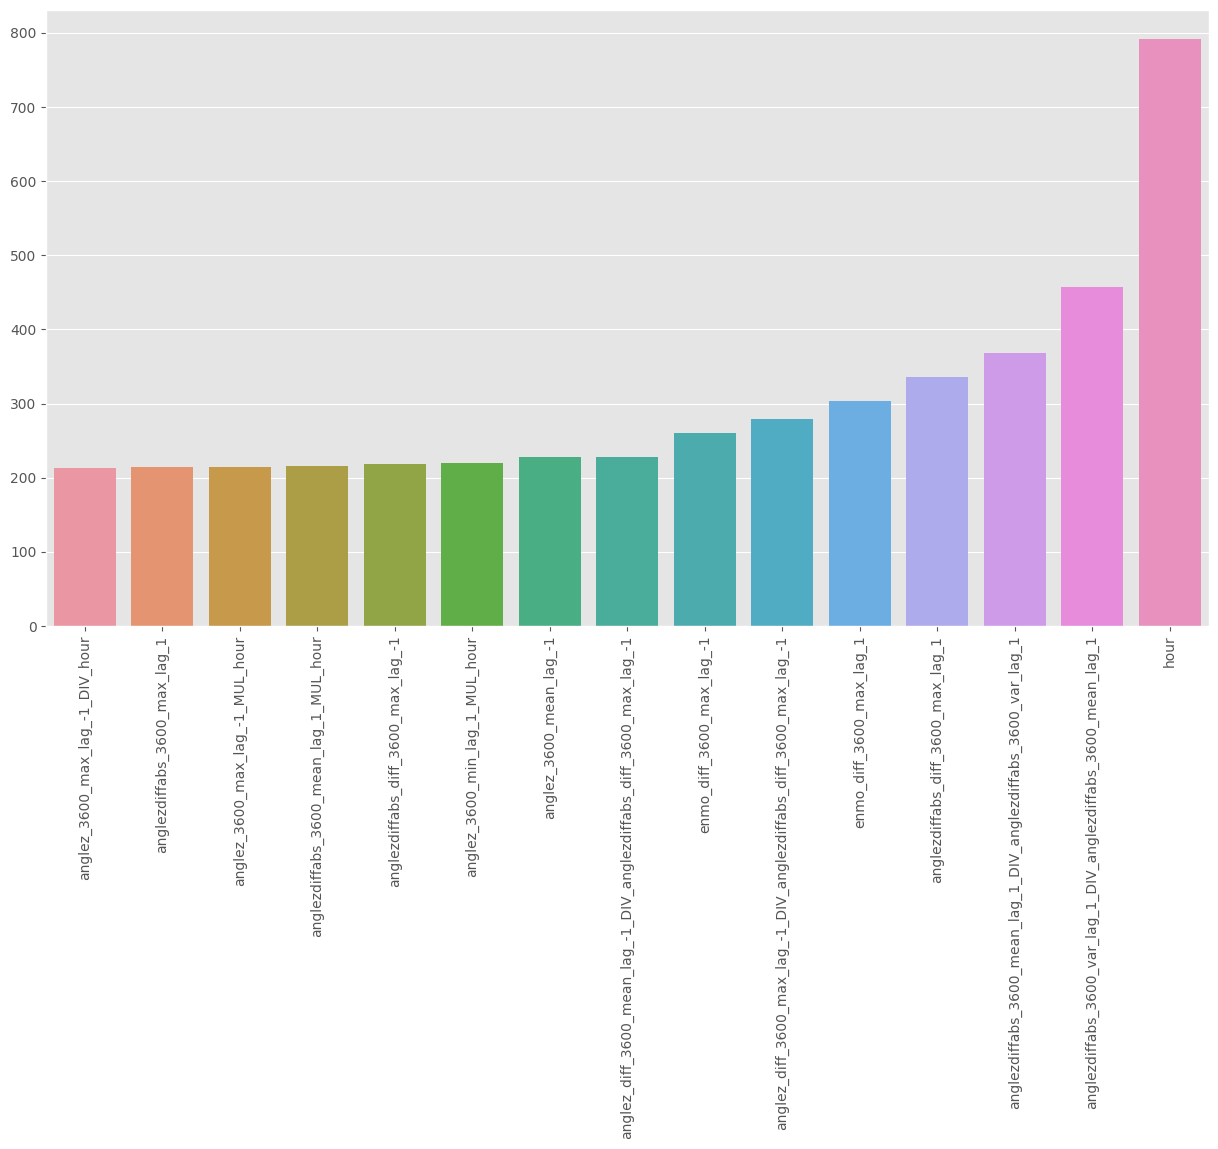

In [79]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])
feature_importance = fi.mean(axis=0).sort_values()
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)

In [83]:
feature_importance.tail(30)

hour_DIV_anglez_3600_max_lag_-1                                        182.8
anglez_3600_min_lag_-1                                                 183.8
anglezdiffabs_diff_3600_max_lag_1_MUL_hour                             185.4
enmo_diff_3600_max_lag_1_MUL_hour                                      187.8
enmo_3600_max_lag_1                                                    191.8
anglez_3600_max_lag_-1_DIV_anglezdiffabs_diff_3600_max_lag_-1          193.8
anglezdiffabs_600_mean_lag_-1                                          193.8
anglez_3600_min_lag_-1_MUL_anglez_diff_3600_max_lag_1                  197.0
anglezdiffabs_diff_3600_max_lag_1_MUL_enmo_diff_3600_max_lag_1         198.6
anglez_3600_var_lag_1                                                  199.6
anglez_diff_3600_mean_lag_1                                            201.2
anglezdiffabs_3600_max_lag_1_MUL_hour                                  202.6
enmo_3600_var_lag_1                                                    203.0

In [84]:
# features_to_drop = feature_importance.head(195).index.to_list()
# df_light = df_light.drop(columns=features_to_drop)
# features = [col for col in df_light.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [86]:
# print(f"Fitting model with {len(features)} features")

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# models = train_model(df_light, kf)